The [NHS dictionary of medicines and devices (dm+d)](https://ebmdatalab.net/what-is-the-dmd-the-nhs-dictionary-of-medicines-and-devices/) has a flags to indicate as to whether a given item should be made available through hospital prescribing [(see tech spec of dm+d)](https://www.nhsbsa.nhs.uk/sites/default/files/2017-02/Data_Model_R2_v3.1_May_2015.pdf). We have [previously investigated some of the hospital flags](https://github.com/ebmdatalab/jupyter-notebooks/blob/3dc1f0d45173ab2dcf3156848df65e7a54be40f2/new_measures/Drafts/Hospital/Primary%20Care%20Prescribing%20of%20%20Hospital%20%20Only%20Medicines.ipynb). 

During our [work on zuclopenthixol](https://ebmdatalab.net/zuclopenthixol-acetate-a-new-kind-of-measure-on-openprescribing/) it became apparent that despite being a "hospital only" medicine, it was classified as such and is perhaps being administered inappropriately in primary care. 

Building on previous work this notebook sets out to explore primary care prescribing of "hospital only" medicines as defined by the [NHS dm+d](https://ebmdatalab.net/what-is-the-dmd-the-nhs-dictionary-of-medicines-and-devices/)


In [1]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps

In [2]:
sql = '''
SELECT
  pct,
  month,
  bnf_name,
  rx.bnf_code,
  SUM(items) AS total_items,
  SUM(actual_cost) AS total_cost
FROM
  hscic.normalised_prescribing_standard AS rx
JOIN (SELECT DISTINCT bnf_code 
  FROM ebmdatalab.dmd.amp
  WHERE avail_restrict = 8) AS dmd
ON
  rx.bnf_code = dmd.bnf_code
JOIN
  hscic.ccgs AS ccgs
ON
  rx.pct=ccgs.code
WHERE
  ccgs.org_type='CCG'
GROUP BY
  pct,
  month,
  bnf_code,
  bnf_name'''


df_hospital = bq.cached_read(sql, csv_path='df_hospital.csv', use_cache=True)
df_hospital['month'] = df_hospital['month'].astype('datetime64[ns]')
df_hospital.head()

,pct,month,bnf_name,bnf_code,total_items,total_cost
0,10Q,2016-03-01,Cefotaxime Sod_Inj 1g Vl,0501021D0AAABAB,1,3.35
1,02H,2016-09-01,Vancomycin HCl_Inj 500mg Vl,0501070U0AAACAC,1,110.26
2,03N,2016-04-01,Vancomycin HCl_Inj 500mg Vl,0501070U0AAACAC,1,6.72
3,99E,2015-12-01,Pantoprazole_Inj 40mg Vl,0103050R0AAACAC,1,283.29
4,99K,2015-12-01,Esomeprazole_I/V Inf 40mg Vl (Dry),0103050E0AAACAC,1,196.50


In [3]:
df_hospital.nunique()

pct              193
month            110
bnf_name         330
bnf_code         206
total_items     1284
total_cost     69175
dtype: int64

In [4]:
df_hospital["bnf_name"].unique()

array(['Cefotaxime Sod_Inj 1g Vl                ',
       'Vancomycin HCl_Inj 500mg Vl             ',
       'Pantoprazole_Inj 40mg Vl                ',
       'Esomeprazole_I/V Inf 40mg Vl (Dry)      ',
       'Promixin_Inj 1 000 000u Vl (Dry)        ',
       'Amoxicillin Sod_Inj 1g Vl               ',
       'Methotrexate_Inj 2.5mg/ml 2ml Vl        ',
       'Amikacin_Inj 250mg/ml 2ml Vl            ',
       'Co-Amoxiclav_Inj 1g/200mg Vl            ',
       'Zoledronic Acid_I/V Inf 800mcg/ml 5ml Vl',
       'Meropenem_Inj 1g Vl (Dry)               ',
       'Zoledronic Acid_I/V Inf 40mcg/ml 100ml  ',
       'Ofev_Cap 150mg                          ',
       'Enbrel_Inj 50mg/ml 1ml Pf MyClic Pen    ',
       'Botox_Inj 100u Vl                       ',
       'Daptomycin_I/V Inf 350mg Vl (Dry)       ',
       'Ceftazidime Pentahyd_Inj 2g Vl', 'Phenylbutazone_Tab 100mg',
       'Pantoprazole_Inj 40mg Vl',
       'Levobupivac HCl_Inj 2.5mg/ml 10ml Amp',
       'Amoxicillin Sod_Inj 500m

There are 330 unique names but at a glance they seem to be overwhelmingly what we would expect to be "hospital only" medicines. However many are for iv antibiotics and some other medicines where some areas have pioneered the use of specialist communiyt teams to adminster medicines in a patients own home to avoid a hospital admission. These may no longer be truly "hospital only".

In [5]:
##groupby bnf name  to see "biggest offenders" in terms of items
df_product = df_hospital.groupby(['bnf_code', 'bnf_name']).sum().sort_values(by = 'total_items', ascending = False).reset_index()
df_product.head(20)

,bnf_code,bnf_name,total_items,total_cost
0,0408010F0AAABAB,Clonazepam_Tab 500mcg,4314716,1.601133e+07
1,0408010F0AAABAB,Clonazepam_Tab 500mcg,2256346,2.551477e+07
2,0408010F0AAACAC,Clonazepam_Tab 2mg,633539,2.324491e+06
3,0408010F0AAACAC,Clonazepam_Tab 2mg,332063,3.088879e+06
4,0501070I0AAABAB,Colistimeth Sod_Inj 1 000 000u Vl,31861,3.292931e+06
5,1501041T0AAABAB,Midazolam HCl_Inj 2mg/ml 5ml Amp,29693,2.091135e+05
6,0501070I0AAABAB,"Colistimeth Sod_Inj 1,000,000u Vl",11756,1.200970e+06
7,0304010G0AAAAAA,Chlorphenamine Mal_Inj 10mg/ml 1ml Amp,8593,2.540313e+05
8,0501021G0AAACAC,Ceftriaxone Sod_Inj 1g Vl,6853,3.588607e+05
9,1501041T0AAABAB,Midazolam HCl_Inj 2mg/ml 5ml Amp,6731,4.208200e+04


Some comments
- Clonazepam would not be considered a "hospital only" medicine. Reviewing dm+d it appears that a [product by Star Pharmaceuticals](https://openprescribing.net/dmd/advanced-search/amp/?search=%5B%22and%22%2C%5B%5B%22nm%22%2C%22contains%22%2C%22clonazep%22%5D%2C%5B%22avail_restrict%22%2C%22equal%22%2C%228%22%5D%5D%5D) has been designated "hospital only" while all other clonazepam products are not. I can't find the SPC for Star Pharmaceutical to see if there is some licnese difference but it is likely that this is a misclassification.
- Colistimeth Sod: This is used iv but also inhaled in treatment of lung infections particularly Cystic Fibrosis. [NHS England states](https://www.england.nhs.uk/wp-content/uploads/2019/04/nhs-england-drugs-list-v14.1.pdf) that when used for treatment of infections related to Cystic Fibrosis it is suiatable for shared care i.e. a GP could prescribe on FP10. 
Reviewing the [	Colistimethate 1million unit powder for solution for injection vials](https://openprescribing.net/dmd/vmp/324311004/)  AMPs more closely we find differences in the designations dependent on product. 

| AMP  | Hospital Only   |
|------|-----------------|
| [Colomycin](https://openprescribing.net/dmd/amp/3108611000001108/)*| No|
|[Promixin](https://openprescribing.net/dmd/amp/4658711000001106/) | Yes|
|[Kent Pharm](https://openprescribing.net/dmd/amp/17652211000001105/) | Yes|
|[AAH](https://openprescribing.net/dmd/amp/18758011000001102/)** | No |

        *The IV produc also has a license to be used by inhalation
        ** Most likely a make believe wholesaler product
    
- Antibiotics: The list is mainly antibiotics or palliatve care medicines. We do see these medicines in the community nowadays as the NHS seeks to keep people out of hospital. Potentially it is inapprorpriate to label these medicines "hospital only".




In [6]:
## let us drop clonazepam before we proceed
df_noclonaz = df_hospital[df_hospital["bnf_name"].str.contains("Clonazepam") == False].sort_values("bnf_name")
df_noclonaz["bnf_name"].unique() ## this is to check I have definitely dropped clona



array(['Abacavir/Lamivudine_Tab 600mg/300mg',
       'Abacavir/Lamivudine_Tab 600mg/300mg     ',
       'Aciclovir Sod_Inf I/V 250mg Vl (Dry)',
       'Aciclovir Sod_Inf I/V 250mg Vl (Dry)    ',
       'Aciclovir Sod_Inf I/V 500mg Vl (Dry)    ',
       'Aciclovir_I/V Inf 25mg/ml 10ml Vl',
       'Aciclovir_I/V Inf 25mg/ml 10ml Vl       ',
       'Aciclovir_I/V Inf 25mg/ml 20ml Vl       ',
       'Adenocor_I/V Inf 3mg/ml 2ml Vl          ',
       'Adenosine_I/V Inf 3mg/ml 2ml Vl         ',
       'Adren_Inj 1/10 000 10ml Pfs             ',
       'Adren_Inj 1/10,000 10ml Pfs', 'Akynzeo_Cap 300mg/0.5mg',
       'Akynzeo_Cap 300mg/0.5mg                 ',
       'Amikacin_Inj 250mg/ml 2ml Vl',
       'Amikacin_Inj 250mg/ml 2ml Vl            ',
       'Amiodarone HCl_Inj 50mg/ml 3ml Amp',
       'Amiodarone HCl_Inj 50mg/ml 3ml Amp      ',
       'Amoxicillin Sod_Inj 1g Vl',
       'Amoxicillin Sod_Inj 1g Vl               ',
       'Amoxicillin Sod_Inj 250mg Vl',
       'Amoxicillin Sod_Inj

(0, 230940.9718124997)

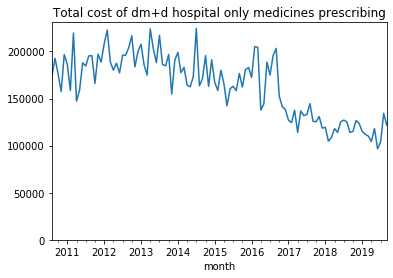

In [7]:
##here we plot trend over time.
df_noclonaz.groupby("month")['total_cost'].sum().plot(kind='line', title="Total cost of dm+d hospital only medicines prescribing")
plt.ylim(0, )

In 2016 there was a substanitial drop and now the costs are approximatelt £125k per month.

## Infrequently prescribed
Frequently prescribed items are probably not truly "hospital only" medicines anymore. We are interetseted in infrequently prescribed medicines that are "hospital only" and possibly a mistake. We highlighted some of this in our [zuclopenthixol blog](https://ebmdatalab.net/zuclopenthixol-acetate-a-new-kind-of-measure-on-openprescribing/) and Callum's [high dose dexamethaone blog](https://ebmdatalab.net/opendemocratisation-of-data-guest-blog-high-dose-dexamethasone/) where things aren't flagged as "hospital only" but probably are. Let us set the threshold of items in a year as similar (but arbitrary) to zuclopenthixol at 75 

In [8]:
infreq = df_noclonaz.loc[(df_noclonaz['month'] >= '2018-11-01') & (df_noclonaz['month'] <= '2019-10-01')] ##restrict to last 12 months



In [9]:
infreq2 = infreq.groupby(["bnf_name", "bnf_code"]).sum().sort_values('total_items', ascending=True).reset_index() ##group and sort by items
infreq2.to_csv("infreq_hosponly.csv") ## export to csv for anyone for further investigation


In [10]:
## Now lets restict to 75 as per rational above
inf_hosp_only = infreq2.loc[(infreq2['total_items'] < 75)]
pd.set_option('display.max_rows', None) 
inf_hosp_only

,bnf_name,bnf_code,total_items,total_cost
0,Talmanco_Tab 20mg,0704050R0BDAAAB,1,387.55282
1,Levofloxacin_I/V Inf 5mg/ml 100ml Vl,0501120X0AAACAC,1,69.62600
2,Tigecycline_I/V Inf 50mg Vl (Dry),0501030Y0AAAAAA,1,809.99619
3,Ciprofloxacin_I/V Inf 2mg/ml 100ml Bag,0501120L0AABEBE,1,130.01919
4,Mag Sulf_Inj 10% 10ml Amp,0905013N0AAABAB,1,61.48454
5,Ofev_Cap 100mg,0801050BTBCAAAA,1,33.39864
6,Daptomycin_I/V Inf 350mg Vl (Dry),0501070Y0AAAAAA,1,57.57535
7,Botox_Inj Pdr 50u Vl,0409030B0BCABAD,1,108.05388
8,Cefuroxime Sod_Inj 1.5g Vl,0501021J0AAACAC,1,394.33493
9,Prostin_E2 Gel 1mg/2.5ml Pfs,0701010I0BBAFAF,1,12.33820


In the last year there are quite a few medicines that I have never heard of, that seem more suitable for secondary care but are being prescribed by practices. This is possible for rare unique cases although we must be mindful for errors abd this requires further investigation. For example is there any circumstance where a GP would prescribe _Rapifen Intensive Care_ which is a powerful opioid? Enbrel cost over £100k in primary care - this should be supplied through secondary care to avail of discounts? 

## Prototype Measure and Maps

In [11]:
##get list size info for a measure per 1000 patients
sql2 = """
SELECT month, 
pct_id AS pct,
AVG(total_list_size) AS list_size
FROM ebmdatalab.hscic.practice_statistics
group by 
month, pct
order by
month, pct,
list_size
"""
df_list = bq.cached_read(sql2, csv_path='listsize.csv')
df_list['month'] = df_list['month'].astype('datetime64[ns]')
df_list.head(5)

,month,pct,list_size
0,2014-10-01,NaN,0.000000
1,2014-10-01,00C,7616.000000
2,2014-10-01,00D,5662.509804
3,2014-10-01,00F,6102.176471
4,2014-10-01,00G,8058.750000


In [12]:
ccg_total_hosp = df_noclonaz.groupby(["month", "pct"])["total_items","total_cost"].sum().reset_index()
ccg_total_hosp.head()

,month,pct,total_items,total_cost
0,2010-08-01,00C,3,19.54
1,2010-08-01,00D,9,815.23
2,2010-08-01,00J,12,1033.15
3,2010-08-01,00K,2,278.16
4,2010-08-01,00L,12,1166.67


In [13]:
#merge dataframes and cost / 10000

hosp_df_1000 = pd.merge(ccg_total_hosp, df_list, on=['month', 'pct'])
hosp_df_1000['cost_per_1000'] = 1000* (hosp_df_1000['total_cost']/hosp_df_1000['list_size'])
hosp_df_1000['items_per_1000'] = 1000* (hosp_df_1000['total_items']/hosp_df_1000['list_size'])
hosp_df_1000.head(5)

,month,pct,total_items,total_cost,list_size,cost_per_1000,items_per_1000
0,2014-10-01,00C,1,621.31,7616.000000,81.579569,0.131303
1,2014-10-01,00D,13,771.78,5662.509804,136.296453,2.295802
2,2014-10-01,00J,11,731.88,6094.536585,120.087884,1.804895
3,2014-10-01,00K,6,386.58,6354.130435,60.839167,0.944268
4,2014-10-01,00L,16,1698.76,6852.085106,247.918695,2.335056


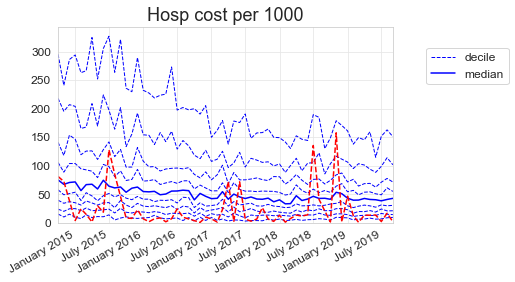

In [14]:
#create sample deciles & prototype measure
charts.deciles_chart(
        hosp_df_1000,
        period_column='month',
        column='cost_per_1000',
        title="Hosp cost per 1000",
        show_outer_percentiles=False)

#add in example CCG (Islington)
df_subject = hosp_df_1000.loc[hosp_df_1000['pct'] == '08H']
plt.plot(df_subject['month'], df_subject['cost_per_1000'], 'r--')

plt.show()

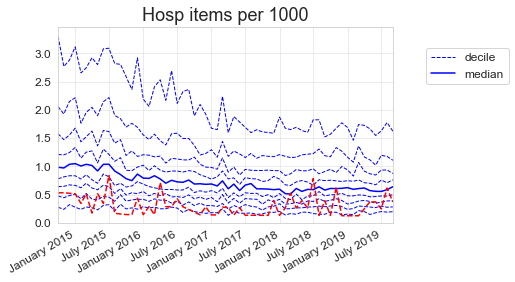

In [15]:
#create sample deciles & prototype measure
charts.deciles_chart(
        hosp_df_1000,
        period_column='month',
        column='items_per_1000',
        title="Hosp items per 1000",
        show_outer_percentiles=False)

#add in example CCG (Islington)
df_subject = hosp_df_1000.loc[hosp_df_1000['pct'] == '08H']
plt.plot(df_subject['month'], df_subject['items_per_1000'], 'r--')

plt.show()

This will require further thought and discussion with users before deploying a measure due to noise of clonzepam, antibiotics etc. Potentially we could exclude this noise?

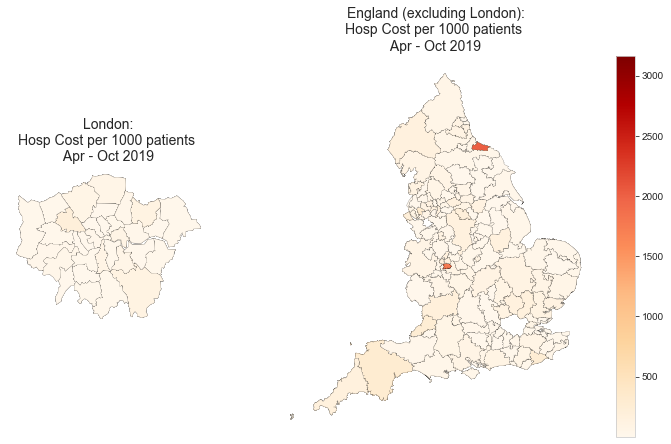

In [16]:
#create choropeth map of cost per 1000 patients
plt.figure(figsize=(12, 7))
latest_hosp_df_1000 = hosp_df_1000.loc[(hosp_df_1000['month'] >= '2019-04-01') & (hosp_df_1000['month'] <= '2019-10-01')]
plt = maps.ccg_map(latest_hosp_df_1000, title="Hosp Cost per 1000 patients \n Apr - Oct 2019 ", column='cost_per_1000', separate_london=True)
plt.show()

In [17]:
## CCGs may like to investigate further so lets produce a file for each of them with last six months data.
# here we create csv files for each CCG to investigate further if they wish - these are now available on GitHub
for i, g in latest_hosp_df_1000.groupby('pct'):
     g.to_csv('{}.csv'.format(i.split('/')[0]), index=False)

## Electronic Health Records (EHR)

Our recent work has show prescribing has an effect on prescribing. Theroretically EHRs could be configured to prevent "hospital only" prescribing. Indeed they may be configured this way already. Here we investigate atterns as per EHR vendor.

In [18]:
sql = """
SELECT
rx.month,
TRIM(Principal_Supplier) AS supplier,
rx.bnf_name,
rx.bnf_code,
SUM(items) AS total_items,
SUM(actual_cost) AS total_cost
FROM
 hscic.normalised_prescribing_standard AS rx
 JOIN (SELECT DISTINCT bnf_code 
  FROM ebmdatalab.dmd.amp
  WHERE avail_restrict = 8 AND bnf_code != '0408010F0AAABAB' AND ##clonazepam
bnf_code != '0408010F0AAACAC') AS dmd ##clonazepam
ON
  rx.bnf_code = dmd.bnf_code
JOIN
  hscic.ccgs AS ccgs
ON
  rx.pct=ccgs.code
JOIN
  alex.vendors AS software
ON
  software.ODS = rx.practice
  AND date(software.Date) = date(rx.month)
GROUP BY
rx.month,
supplier,
rx.bnf_name,
rx.bnf_code
ORDER BY
month"""



df_ehr_hosp = bq.cached_read(sql, csv_path='df_ehr_hosp.csv')
df_ehr_hosp['month'] = df_ehr_hosp['month'].astype('datetime64[ns]')
df_ehr_hosp.head(3)

,month,supplier,bnf_name,bnf_code,total_items,total_cost
0,2016-01-01,EMIS,Colistimeth Sod_Inj 1 000 000u Vl,0501070I0AAABAB,243,23732.72
1,2016-01-01,Microtest,Pamidronate Disod_I/V Inf 9mg/ml 10ml Vl,0606020P0AAAHAH,1,157.44
2,2016-01-01,EMIS,Vancomycin HCl_Inj 500mg Vl,0501070U0AAACAC,5,291.92


In [19]:
##groupby bnf name  to see "biggest offenders" in terms of items
df_product_ehr = df_ehr_hosp.groupby(['bnf_code', 'bnf_name']).sum().sort_values(by = 'total_items', ascending = False)
df_product_ehr

,,total_items,total_cost
bnf_code,bnf_name,,
0501070I0AAABAB,"Colistimeth Sod_Inj 1,000,000u Vl",11055,1.129714e+06
1501041T0AAABAB,Midazolam HCl_Inj 2mg/ml 5ml Amp,5914,3.719225e+04
0501070I0AAABAB,Colistimeth Sod_Inj 1 000 000u Vl,4620,4.741567e+05
1501041T0AAABAB,Midazolam HCl_Inj 2mg/ml 5ml Amp,3262,2.340967e+04
0304010G0AAAAAA,Chlorphenamine Mal_Inj 10mg/ml 1ml Amp,2736,2.414351e+05
0211000P0AAAAAA,Tranexamic Acid_Inj 100mg/ml 5ml Amp,1744,4.058949e+04
0501021G0AAADAD,Ceftriaxone Sod_Inj 2g Vl,1498,2.230101e+05
0501040H0AAAMAM,Gentamicin Sulf_Inj 40mg/ml 2ml Vl,1419,8.545521e+04
0501021G0AAACAC,Ceftriaxone Sod_Inj 1g Vl,1316,7.525170e+04


Text(0.5, 1.0, 'total hosp only items per EHR vendor')

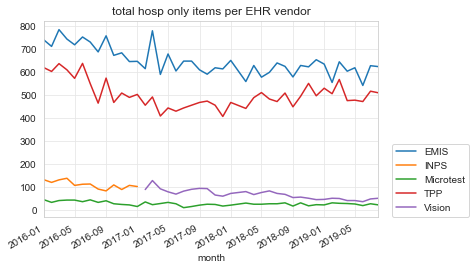

In [20]:
df_ehr_hosp.groupby(['month', 'supplier']).sum()['total_items'].unstack().plot.line()
plt.legend(loc=(1.04,0))
plt.title("total hosp only items per EHR vendor")

There is no striking trend but the downwar trend in overall prescribing came circa 2016 and we only have EHR data until 2016. We should have a look at user interface to support further work.